In [1]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
#!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2024-11-10 12:41:35--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.37.88, 54.231.166.248, 52.217.138.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.37.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  68.1MB/s    in 5.0s    

2024-11-10 12:41:40 (65.3 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/aipnd-project-master/aipnd-project-master

/content/drive/MyDrive/aipnd-project-master/aipnd-project-master


In [4]:
!ls flowers

test  train  valid


In [5]:
!python -m train --model_name vgg --hidden_units 1000 --lr 0.003 --epochs 5

In [6]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled.

2.5.0+cu121
False


In [7]:
# Imports here
import torch.optim as optim
from torch.utils import data
from PIL import Image
import numpy as np
import os, random
import signal
from torch import nn
import torch.nn.functional as F
import tqdm
from torchvision import datasets, transforms, models

from contextlib import contextmanager

import requests


import matplotlib
import matplotlib.pyplot as plt


%config IPCompleter.greedy=True

In [8]:
from torchvision import datasets, transforms

# Define the correct paths based on your directory structure
train_dir = 'flowers/train'
valid_dir = 'flowers/valid'
test_dir = 'flowers/test'

# Define data augmentation and normalization transforms for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms for the validation and testing sets
valid_transforms = test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the flower species datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders for the training, validation, and testing sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [9]:
# Import necessary libraries
import json
import collections

# Load the JSON file containing category names
with open('cat_to_name.json', 'r') as file:
    category_names = json.load(file)

# Convert category IDs to integers and store in a dictionary
category_names = {int(key): value for key, value in category_names.items()}

# Sort the category names in ascending order of their IDs
sorted_category_names = collections.OrderedDict(sorted(category_names.items()))

# Print the sorted category names
print("Sorted Category Names:")
print(sorted_category_names)

Sorted Category Names:
OrderedDict([(1, 'pink primrose'), (2, 'hard-leaved pocket orchid'), (3, 'canterbury bells'), (4, 'sweet pea'), (5, 'english marigold'), (6, 'tiger lily'), (7, 'moon orchid'), (8, 'bird of paradise'), (9, 'monkshood'), (10, 'globe thistle'), (11, 'snapdragon'), (12, "colt's foot"), (13, 'king protea'), (14, 'spear thistle'), (15, 'yellow iris'), (16, 'globe-flower'), (17, 'purple coneflower'), (18, 'peruvian lily'), (19, 'balloon flower'), (20, 'giant white arum lily'), (21, 'fire lily'), (22, 'pincushion flower'), (23, 'fritillary'), (24, 'red ginger'), (25, 'grape hyacinth'), (26, 'corn poppy'), (27, 'prince of wales feathers'), (28, 'stemless gentian'), (29, 'artichoke'), (30, 'sweet william'), (31, 'carnation'), (32, 'garden phlox'), (33, 'love in the mist'), (34, 'mexican aster'), (35, 'alpine sea holly'), (36, 'ruby-lipped cattleya'), (37, 'cape flower'), (38, 'great masterwort'), (39, 'siam tulip'), (40, 'lenten rose'), (41, 'barbeton daisy'), (42, 'daffod

In [10]:
model = models.efficientnet_b2(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 60.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# Freeze the pre-trained model weights
for param in model.parameters():
    param.requires_grad = False

# Identify trainable layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer {name} is trainable")
    else:
        print(f"Layer {name} is frozen")

Layer features.0.0.weight is frozen
Layer features.0.1.weight is frozen
Layer features.0.1.bias is frozen
Layer features.1.0.block.0.0.weight is frozen
Layer features.1.0.block.0.1.weight is frozen
Layer features.1.0.block.0.1.bias is frozen
Layer features.1.0.block.1.fc1.weight is frozen
Layer features.1.0.block.1.fc1.bias is frozen
Layer features.1.0.block.1.fc2.weight is frozen
Layer features.1.0.block.1.fc2.bias is frozen
Layer features.1.0.block.2.0.weight is frozen
Layer features.1.0.block.2.1.weight is frozen
Layer features.1.0.block.2.1.bias is frozen
Layer features.1.1.block.0.0.weight is frozen
Layer features.1.1.block.0.1.weight is frozen
Layer features.1.1.block.0.1.bias is frozen
Layer features.1.1.block.1.fc1.weight is frozen
Layer features.1.1.block.1.fc1.bias is frozen
Layer features.1.1.block.1.fc2.weight is frozen
Layer features.1.1.block.1.fc2.bias is frozen
Layer features.1.1.block.2.0.weight is frozen
Layer features.1.1.block.2.1.weight is frozen
Layer features.1.1

In [12]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(1408, out_features=102, bias=True)
)

for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"Non-trainable layer: {name}")
    else:
        print(f"Trainable layer: {name}")

Non-trainable layer: features.0.0.weight
Non-trainable layer: features.0.1.weight
Non-trainable layer: features.0.1.bias
Non-trainable layer: features.1.0.block.0.0.weight
Non-trainable layer: features.1.0.block.0.1.weight
Non-trainable layer: features.1.0.block.0.1.bias
Non-trainable layer: features.1.0.block.1.fc1.weight
Non-trainable layer: features.1.0.block.1.fc1.bias
Non-trainable layer: features.1.0.block.1.fc2.weight
Non-trainable layer: features.1.0.block.1.fc2.bias
Non-trainable layer: features.1.0.block.2.0.weight
Non-trainable layer: features.1.0.block.2.1.weight
Non-trainable layer: features.1.0.block.2.1.bias
Non-trainable layer: features.1.1.block.0.0.weight
Non-trainable layer: features.1.1.block.0.1.weight
Non-trainable layer: features.1.1.block.0.1.bias
Non-trainable layer: features.1.1.block.1.fc1.weight
Non-trainable layer: features.1.1.block.1.fc1.bias
Non-trainable layer: features.1.1.block.1.fc2.weight
Non-trainable layer: features.1.1.block.1.fc2.bias
Non-traina

In [13]:
# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with a learning rate of 0.001
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Check if a CUDA-enabled GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the available device (GPU or CPU)
model.to(device)

# Print a message indicating the device being used
print(f"Using device: {device}")

Using device: cpu


In [14]:

import tqdm

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    train_loader_progress = tqdm.tqdm(train_loader, total=len(train_loader), desc="Training")

    for inputs, labels in train_loader_progress:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += loss.item()  # Accumulate loss
        train_loader_progress.set_postfix(loss=epoch_loss / (train_loader_progress.n + 1))

    train_loss = epoch_loss / len(train_loader)  # Average loss for the epoch
    return train_loss

def validate_model(model, valid_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    epoch_loss = 0.0
    correct_predictions, total_samples = 0, 0
    valid_loader_progress = tqdm.tqdm(valid_loader, total=len(valid_loader), desc="Validating")

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in valid_loader_progress:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            epoch_loss += loss.item()  # Accumulate loss
            _, predicted_labels = outputs.max(1)  # Get predicted labels
            total_samples += labels.size(0)  # Update total samples
            correct_predictions += (predicted_labels == labels).sum().item()  # Update correct predictions
            valid_loader_progress.set_postfix(loss=epoch_loss / (valid_loader_progress.n + 1))

    valid_loss = epoch_loss / len(valid_loader)  # Average loss for the validation set
    accuracy = 100 * correct_predictions / total_samples  # Calculate accuracy
    return valid_loss, accuracy

In [15]:
num_epochs = 5
train_loss_history, valid_loss_history = [], []

for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_loss_history.append(train_loss)

    # Validate the model
    valid_loss, accuracy = validate_model(model, valid_loader, criterion, device)
    valid_loss_history.append(valid_loss)

    # Print the results
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

Validating: 100%|██████████| 13/13 [05:27<00:00, 25.16s/it, loss=1.84]


Epoch [1/5], Train Loss: 3.2149, Valid Loss: 1.8436, Accuracy: 78.73%


Validating: 100%|██████████| 13/13 [02:20<00:00, 10.84s/it, loss=1]


Epoch [2/5], Train Loss: 1.6750, Valid Loss: 1.0019, Accuracy: 87.90%


Validating: 100%|██████████| 13/13 [02:21<00:00, 10.87s/it, loss=0.714]


Epoch [3/5], Train Loss: 1.1496, Valid Loss: 0.7140, Accuracy: 91.08%


Validating: 100%|██████████| 13/13 [02:21<00:00, 10.88s/it, loss=0.583]


Epoch [4/5], Train Loss: 0.9168, Valid Loss: 0.5830, Accuracy: 91.32%


Validating: 100%|██████████| 13/13 [02:22<00:00, 10.93s/it, loss=0.494]

Epoch [5/5], Train Loss: 0.7979, Valid Loss: 0.4938, Accuracy: 92.05%


In [60]:
import tqdm

# Define the test function
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions, total_samples = 0, 0
    test_loader_progress = tqdm.tqdm(test_loader, total=len(test_loader), desc="Testing")

    # Check if the test_loader is empty
    if len(test_loader) == 0:
        print("Test loader is empty.")
        return

    # Check if the dataset is empty
    if len(test_loader.dataset) == 0:
        print("Test dataset is empty.")
        return

    print("Starting testing...")  # Debugging print

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader_progress:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            test_loss += loss.item()  # Accumulate loss

            _, predicted_labels = outputs.max(1)  # Get predicted labels
            total_samples += labels.size(0)  # Update total samples
            correct_predictions += (predicted_labels == labels).sum().item()  # Update correct predictions
            test_loader_progress.set_postfix(loss=test_loss / (test_loader_progress.n + 1))

    if total_samples > 0:  # Check to avoid division by zero
        average_test_loss = test_loss / len(test_loader)  # Average loss for the test set
        test_accuracy = 100 * correct_predictions / total_samples  # Calculate accuracy

        print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    else:
        print("No samples in the test set.")

# Call the test_model function after training and validation
test_model(model, test_loader, criterion, device)

Testing:   0%|          | 0/13 [00:00<?, ?it/s]

Starting testing...


Testing: 100%|██████████| 13/13 [05:41<00:00, 26.27s/it, loss=0.53]

Test Loss: 0.5303, Test Accuracy: 90.72%


In [34]:

# Attach class_to_idx to the model
model.class_to_idx = train_data.class_to_idx

# Create a checkpoint dictionary
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_epochs': num_epochs,
    'class_to_idx': model.class_to_idx
}

# Save the checkpoint
torch.save(checkpoint, 'model_checkpoint.pth')
print("Checkpoint saved successfully.")

Checkpoint saved successfully.


In [46]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'),weights_only=True)
    model = models.efficientnet_b2(pretrained=True)

    # Freeze the parameters (if needed)
    for param in model.parameters():
        param.requires_grad = False

    # Load the classifier structure
    model.classifier = checkpoint['classifier']

    # Load the state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load the class_to_idx mapping
    model.class_to_idx = checkpoint['class_to_idx']

    # Optionally, set the model to evaluation mode
    model.eval()

    return model

In [47]:
from collections import OrderedDict
def load_checkpoint(filepath):
        checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
        model = models.efficientnet_b2(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        model.classifier = checkpoint['classifier'] # load classifier

        model.load_state_dict(checkpoint['model_state_dict'])
        model.class_to_idx = checkpoint['class_to_idx']
        model.eval()

        return model

In [51]:

def process_image(image_path):
    pil_image = Image.open(image_path)
    pil_image = pil_image.resize((256, 256))
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = (pil_image.width + 224) / 2
    bottom = (pil_image.height + 224) / 2
    pil_image = pil_image.crop((left, top, right, bottom))
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    np_image = np_image.transpose((2, 0, 1))
    return torch.tensor(np_image).float()

def predict(image_path, model, topk=5):
    image = process_image(image_path)
    image = image.unsqueeze(0)
    model.eval()

    # Move the image to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        ps = torch.nn.functional.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(topk, dim=1)

    # Convert to lists and move to CPU
    top_p = top_p.cpu().numpy()[0]
    top_class = top_class.cpu().numpy()[0]

    # Invert the class_to_idx dictionary to get class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[i] for i in top_class]

    return top_p, top_classes

In [55]:
def display_image(image_tensor, axis=None, image_title=None):

    if axis is None:
        fig, axis = plt.subplots()

    # Convert the image tensor from (C, H, W) to (H, W, C)
    image_array = image_tensor.numpy().transpose((1, 2, 0))

    # Reverse normalization
    mean_values = np.array([0.485, 0.456, 0.406])
    std_values = np.array([0.229, 0.224, 0.225])
    image_array = std_values * image_array + mean_values

    # Ensure pixel values are within [0, 1]
    image_array = np.clip(image_array, 0, 1)

    axis.imshow(image_array)
    if image_title:
        axis.set_title(image_title)  # Set the title if provided
    axis.axis('off')  # Hide axes for better visualization

    return axis

import seaborn as sns

def visualize_prediction(image_file_path, trained_model):
    """Visualize the prediction results for a given image."""
    plt.figure(figsize=(6, 10))

    # Display the image
    subplot_axis = plt.subplot(2, 1, 1)
    processed_image = process_image(image_file_path)

    # Extract the class from the image path
    class_label = image_file_path.split('/')[-2]
    image_title = cat_to_name.get(class_label, 'Unknown Flower')  # Handle missing keys
    display_image(processed_image, axis=subplot_axis, image_title=image_title)

    # Get predictions
    probabilities, predicted_classes = predict(image_file_path, trained_model)
    class_labels = [cat_to_name.get(cls, 'Unknown Flower') for cls in predicted_classes]  # Handle missing keys

    # Plot the probabilities
    plt.subplot(2, 1, 2)
    sns.barplot(x=probabilities, y=class_labels, color=sns.color_palette()[0])
    plt.xlabel('Probability')
    plt.ylabel('Class Labels')
    plt.title('Top Predictions')
    plt.show()

print("Prediction visualization function is ready.")

Prediction visualization function is ready.


Sorted Category Names:
OrderedDict([(1, 'pink primrose'), (2, 'hard-leaved pocket orchid'), (3, 'canterbury bells'), (4, 'sweet pea'), (5, 'english marigold'), (6, 'tiger lily'), (7, 'moon orchid'), (8, 'bird of paradise'), (9, 'monkshood'), (10, 'globe thistle'), (11, 'snapdragon'), (12, "colt's foot"), (13, 'king protea'), (14, 'spear thistle'), (15, 'yellow iris'), (16, 'globe-flower'), (17, 'purple coneflower'), (18, 'peruvian lily'), (19, 'balloon flower'), (20, 'giant white arum lily'), (21, 'fire lily'), (22, 'pincushion flower'), (23, 'fritillary'), (24, 'red ginger'), (25, 'grape hyacinth'), (26, 'corn poppy'), (27, 'prince of wales feathers'), (28, 'stemless gentian'), (29, 'artichoke'), (30, 'sweet william'), (31, 'carnation'), (32, 'garden phlox'), (33, 'love in the mist'), (34, 'mexican aster'), (35, 'alpine sea holly'), (36, 'ruby-lipped cattleya'), (37, 'cape flower'), (38, 'great masterwort'), (39, 'siam tulip'), (40, 'lenten rose'), (41, 'barbeton daisy'), (42, 'daffod

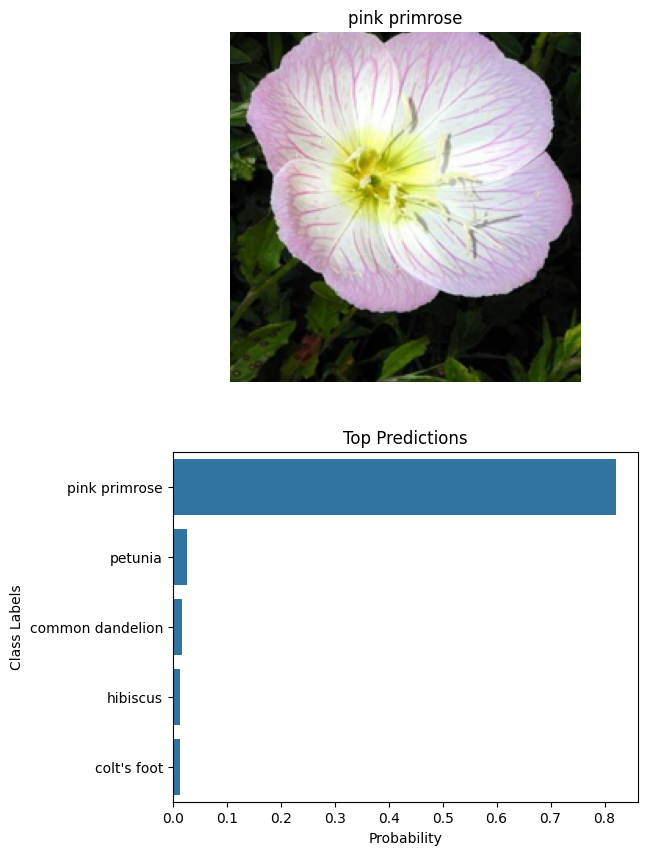

Prediction visualization completed successfully.


In [58]:
import json
import collections

# Load the JSON file containing category names
with open('cat_to_name.json', 'r') as file:
    category_names = json.load(file)

# Convert category IDs to integers and store in a dictionary
category_names = {int(key): value for key, value in category_names.items()}

# Sort the category names in ascending order of their IDs
sorted_category_names = collections.OrderedDict(sorted(category_names.items()))

# Print the sorted category names
print("Sorted Category Names:")
print(sorted_category_names)

# Load the model and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Model has been successfully loaded onto the device:", device)

# Specify the image path
image_file_path = '/content/flowers/test/1/image_06743.jpg'

# Process the image
processed_image = process_image(image_file_path)
print("Image has been processed successfully.")

# Make predictions
predicted_probabilities, predicted_classes = predict(image_file_path, model)
print("Predicted probabilities: ", predicted_probabilities)
print("Predicted classes: ", predicted_classes)

# Modify the visualize_prediction function to use category_names
def visualize_prediction(image_file_path, trained_model):
    """Visualize the prediction results for a given image."""
    plt.figure(figsize=(6, 10))

    # Display the image
    subplot_axis = plt.subplot(2, 1, 1)
    processed_image = process_image(image_file_path)

    # Extract the class from the image path
    class_label = image_file_path.split('/')[-2]
    image_title = category_names.get(int(class_label), 'Unknown Flower')  # Use category_names here
    display_image(processed_image, axis=subplot_axis, image_title=image_title)

    # Get predictions
    probabilities, predicted_classes = predict(image_file_path, trained_model)
    class_labels = [category_names.get(int(cls), 'Unknown Flower') for cls in predicted_classes]  # Use category_names here

    # Plot the probabilities
    plt.subplot(2, 1, 2)
    sns.barplot(x=probabilities, y=class_labels, color=sns.color_palette()[0])
    plt.xlabel('Probability')
    plt.ylabel('Class Labels')
    plt.title('Top Predictions')
    plt.show()

# Visualize the prediction results
visualize_prediction(image_file_path, model)
print("Prediction visualization completed successfully.")

#References

1. https://github.com/niloydebbarma-code/Udacity-Project-2-my-own-image-classifier/tree/main
2. https://github.com/vishalnarnaware/Create-your-own-Image-Classifier
3. https://github.com/udacity/aipnd-project
